In this lecture, we will dig a bit further into ANN and see one of its applications in language model. We will be studying a technique called **word embedding**. For this session, it's better to run the model (particularly the pre-trained model) in cloud or computers with very large memories and GPUs. Otherwise, it may run into memory issues.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import string
import nltk
import re
import gensim 

from sklearn.decomposition import PCA
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import blankline_tokenize
from nltk.util import ngrams
from nltk.probability import FreqDist

import gensim.downloader as api

%matplotlib inline

In [2]:
# warnings.filterwarnings("ignore")

path="C:\\Users\\GAO\\python workspace\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

# path="C:\\Users\\pgao\\Documents\\PGZ Documents\\Programming Workshop\\PYTHON\\Open Courses on Python\\Udemy Course on Python\Introduction to Data Science Using Python\\datasets"
# os.chdir(path)

print('Gensim version: ', gensim.__version__) # we need 3.8.3 version

Gensim version:  3.8.3


The foundation of the word embedding is the distributed representation theory. So we will go over the theory first. 

### I. Distributed Representation and Neural Probalistic Language Model (NPLM)

Language modeling is the problem of modeling the probability distribution of natural language texts. That is, we would like to be able to determine how likely a given sentence is to be uttered. This is an instance of the more general problem of distribution modeling, i.e. learning a model which tries to approximate the distribution which some dataset is drawn from. One way to look at the problem is to put the problem into a Bayesian setting. Suppose we are building a speech recognition system. Given an acoustic signal $a$, we'd like to infer the sentence $s$ (or a set of candidate sentences) that was probably spoken. One way to do this is to build a generative model. In this case, such a model consists of two probability measures: 1) the observation model and 2) the prior. The observation model is $Pr(a|s)$ which tells us how likely a sentence is to lead to a given acoustic signal. The prior $Pr(s)$ tells us how likely a given sentence is to be spoken. Given these two distributions, we can combine them using Bayes' rule to infer the posterior distribution over sentences. The idea is $Pr(s|a)=\frac{Pr(a|s)Pr(s)}{\sum_{s'}Pr(a|s')Pr(s')}$. Because the denominator is simply a normalization term, we often say the posterior is proportional to the product of prior and the observation model. 

Having the prior is important, and this is the nature of the language modeling. Suppose we're going to recast the distribution modeling task as a sequential prediction task. Suppose we're given a corpus of sentences $s_{1}, ...s_{N}$. We'll make the simplifying assumption that the sentences are independent. This means that their probabilities multiply s.t. $Pr(s_{1}, ...s_{N})=\prod_{j=1}^{N}Pr(s_{j})$. Hence, we can talk instead about modeling the distribution over sentences. We'll try to fit a model which represents a distribution $p_{\theta}(s)$, parameterized by $\theta \in \Theta$ (here $s$ denotes a vector of sentences). This is where maximum likelihood comes in handy. 

A sentence is essentially a sequence of words $s=\{w_{t}\}_{t=1}^{T}$. The chain rule of conditional probability implies that we can rewrite our prior as $Pr(s)=Pr(w_{1}, w_{2},...w_{t},...w_{T})=Pr(w_{1})Pr(w_{2}|w_{1})Pr(w_{3}|w_{1}, w_{2})...Pr(w_{T}|w_{1},...w_{T-1})$. Hence, the language modeling problem is equivalent to being able to predict the next word. We typically make a **Markov assumption**, i.e. that the distribution over the next word only depends on the preceding few words. As an example, if we use a context of length 3, this means $Pr(w_{t}|w_{1},...w_{t-1})=Pr(w_{t}|w_{t-3}, w_{t-2}, w_{t-1})$. Such a model is called memoryless, since it has no memory of what occurred way earlier in the sentence. When we decompose the distribution modeling problem into a sequential prediction task with limited context lengths, we simplified the problem using an autoregressive model.

Now let's talk more about the Markov assumption. The simplest sort of Markov model is a conditional probability table (CPT), where we explicitly represent the distribution over the next word given its context words. This is a table with a row for every possible context word senence, and a column for every word, and the entry gives the conditional probability. Since each row represents a probability distribution, the entries must be nonnegative, and the entries in each row must sum to 1. Otherwise, the numbers can be anything. The simplest way to estimate a CPT is using the empirical counts, i.e., the number of times a sequence of words occurs in the training corpus. For instance, $Pr(w_{3} = \text{cat} | w_{1} = \text{the}, w_{2} = \text{fat})= \frac{\text{count(the fat cat)}}{\text{count(fat)}}$. In this example, it requires us count the number of occurrences of all sequences of length 2 and 3. Sequences of length $n$ are called n-grams, and a model based on counting such sequences is called an **n-gram model**. Observe that the number of possible contexts grows exponentially in $n$. This means that except for very small $n$, we're unlikely to see all possible n-grams in the training corpus, and many or most of the counts will be 0. This problem is referred to as **data sparsity**. There's one problem fundamental to the n-gram approach: it's hard to share information between related words. If we see the sentence "_The cat got squashed in the garden on Friday_", we should estimate a higher probability of seeing the sentence "_The dog got to be taken care of in the yard on Monday_", even though these two sentences have few words in common. 

The above discussion motivates our study on word embedding. Conditional probability tables are a kind of **localist representation**, which means a given piece of information (e.g. the probability of seeing "cat" after "the fat") is stored in just one place. If we'd like to share information between related words, we might want to use a **distributed representation**, where the same piece of information would be distributed throughout the whole representation. Below is a conceptual example:

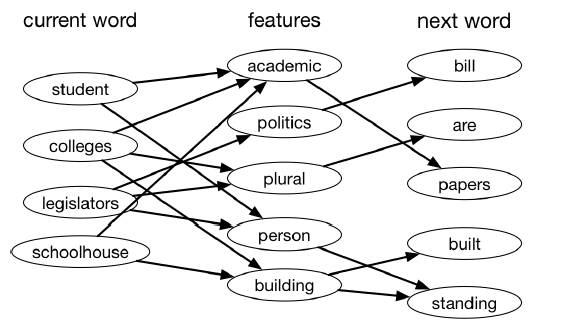

In [4]:
from IPython.display import Image
Image("distributed representation.PNG", width=200, height=200)

As we see, the information about a given word (next word) is distributed throughout the representation. The middle section "_features_" is of course not directly observable. But they link the current and next word together in some dimension. So now we need a model that learns the distributed representations of language. We will call this classic model **neural probabilistic language model (NPLM)**, or just **neural language model (NLM)** (see Bengio et. al. 2006) . It turns out that all we need is a twist of a basic multilayer perceptron (MLP) (thus it has a prediction task). Here is what the model looks like:

   1. Input: the sequence of context words (previous $L$ words where $L$ is a user-defined integer)
   2. Target: (distribution of) the next word 
   3. Loss: cross entropy 

The real question here is the following: how can we set up the network structure to model the distribution of words like above. Below is a sketch of the network topology from the original paper. The main new concept here is the table look-up in the first layer. The network learns a representation of every word in the dictionary as a vector, and keeps these in a 'lookup table'. This can be seen as a matrix $C$, where each column gives the vector representation of one word:

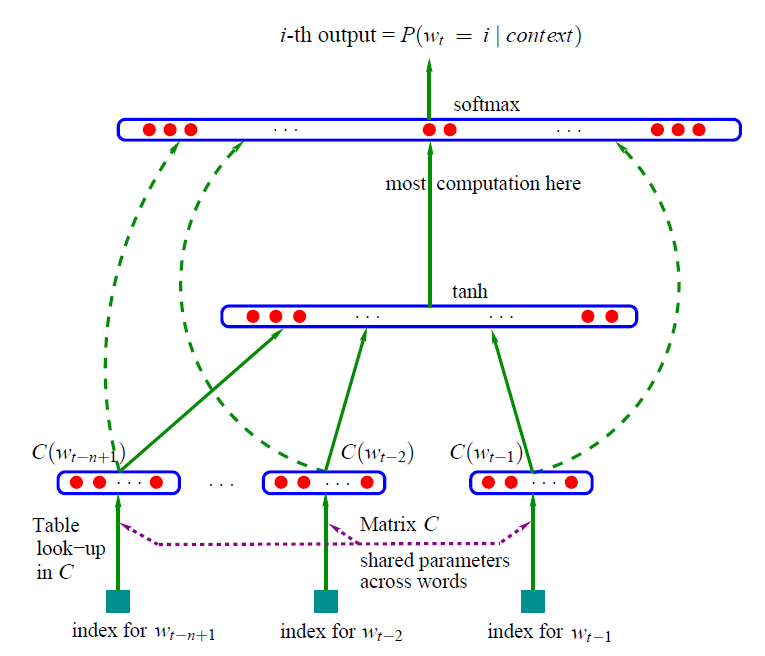

In [26]:
from IPython.display import Image
Image("classic NLM original paper.PNG", width=350, height=350)

We won't go over the details of this model presented above. The intuition of the model is more important than the details of its network topology. The objective is to learn a good model $f(w_{t},...w_{t−j+1})$ in the sense that it gives high out-of-sample likelihood. We decompose the function $f(.)$ into two parts. First, we need a mapping $C$ from any element of vocabulary to a real vector. It represents the distributed feature vectors associated with each word in the vocabulary. In practice, $C$ is represented by a matrix, which is what that 'lookup' table does. Second, we need the probability function over words, expressed with $C$: a function $g(.)$ that maps an input sequence of feature vectors for words in context, to a conditional probability distribution over words in the set of vocabulary (denoted by $V$) for the next word. So really, the neural network has one hidden layer beyond the word features
mapping, and optionally, direct connections from the word features to the output. Therefore there
are really two hidden layers: the shared word features layer on the same level of $C$, which has no non-linearity, and the ordinary hidden layer with some activation function (the original paper used $tanh(.)$). The output layer is activated by a softmax function due to the choice of cross-entropy. This architecture also includes a dotted connection from the embedding layer to the output layer; we won't go into too much detail here to explain why the network looks like this, but roughly speaking, it helps information travel faster through the network. There are two merits of this model:

   1. The number of free parameters only scales linearly with $V$, the number of words in the vocabulary (so our model parameter space won't explode, therefore solving the curse of dimensionality problem). Observe that unlike n-gram models, the neural language model is very compact, even for long context lengths. While the size of the CPTs grows exponentially in the context length, the size of the network (number of weights, or number of units) grows also linearly in the context length.
   2. This model can easily deal with out-of-vocabulary words (and even assign them a probability). The main idea is to first guess an initial feature vector for such a word, by taking a weighted convex combination of the feature vectors of other words that could have occurred in the same context, with weights proportional to their conditional probability.
   
This is where the word _embedding_ come from (also known as the feature vector, or encoding, emphasizing that it picks out semantically relevant features that might be useful for downstream tasks as well as the fact that it's a location in a high-dimensional space). The idea is that we map words into features (embeddings), and then we feed these features into a shallow neural network with softmax function for the output layer to predict the next word through a MLP. 

### II. An Overview on Word Embeddings

The discussion on NPLM prompts us to think whether we can extend the idea to both supervised and unsupervised learning tasks. The central spirit of the model lies in the fact that we can use a concept called word embeddings as word representations, allowing words with similar meaning to have a similar representation. For example, words like 'apple' and 'banana' should be placed close whereas the word 'book' should be far away from these words. In a broader sense, word embedding will create the vector of 'fruits' which will be placed far away from vector representation of 'books'. In unsupervised learning tasks, word embeddings can be used to figure out word 'distances' for clustering purposes or measuring word similarities. In the supervised learning tasks, word embeddings can be used as features to train more sophisticated neural network models in NLP tasks. But all in all, the linguistic theory behind this approach, namely the distributional hypothesis by Zillig Harris (1954), is the foundation of all these. Harris believed that words that have similar context will have similar meanings. 

Word embeddings has a lot of applications:

   - Computing similar words, or creating a group of related words
   - Extracting features for text classification 
   - Performing document clustering and document grouping and other possibly related tasks such as sentiment analysis and syntactic analysis etc.

The most famous word embedding techniques include the following:

   - Word2Vec (created by Google 2013)
   - Doc2Vec and Doc2VecC 
   - GloVe (created by Stanford 2014)
   - FastText (created by Facebook 2017)
   - Poincare embeddings (created bu Facebook 2017)

In this tutorial we will go over the basic model from Word2Vec. Majority of the models can be implemented by the Gensim library, except GloVe. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. Like other word embeddings, it can be used in transfer learning where people simply download the pre-trained embeddings. More information about GloVe can be found from here: 

   - https://nlp.stanford.edu/projects/glove/. 

In this tutorial, we will use the stable version of Gensim 3.8.3. Currently Gensim is going through some big changes for versions above 4.0.1. The new version is more powerful but a bit unstable. So we will use the stable version in this tutorial. Details regarding the differences between these versions can be found here:

   - https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4. 

### III. Training the Word2Vec Model

Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus. There are two sub-models of Word2Vec:

   1. Continuous bag-of-words (CBOW) model
   2. Skip-gram model
   
The CBOW model learns the embedding by predicting the current word based on its context. The continuous skip-gram model learns by predicting the surrounding words given a current word. Both are neural network models and are focused on learning about words given their local usage context, where the context is defined by a window of neighboring words. This window is a configurable parameter of the model and it has a great impact on the result. In short, large windows tend to produce more topical similarities whereas smaller windows tend to produce more functional and syntactic similarities (c.f. Goldberg 2017, p.128). This makes sense because when the window is small, structure of the sentence and grammar are more likely to be picked up by the model whereas more topics will be gathered when the window is larger.

Below is a summary of their network topology:

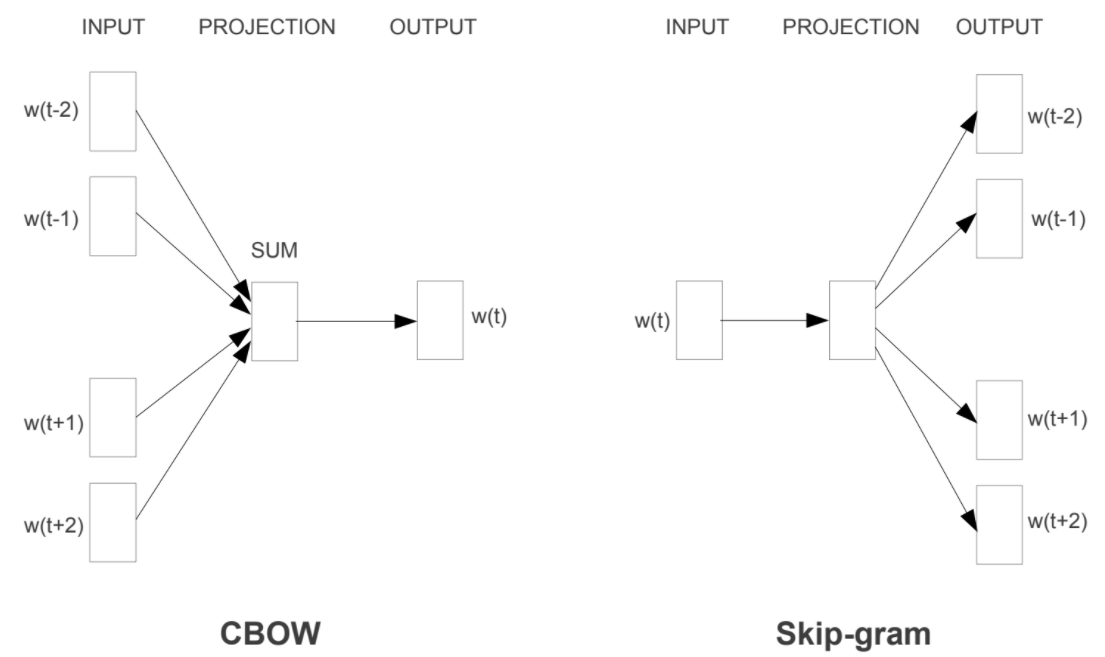

In [6]:
from IPython.display import Image
Image("CBOW and Skip-gram architecture.PNG", width=350, height=350)

According to the official Gensim's documentation, the skip-gram model, for example, takes in pairs (word1, word2) generated by moving a window across text data, and trains a 1-hidden-layer neural network based on the synthetic task of given an input word, giving us a predicted probability distribution of nearby words to the input. A virtual one-hot encoding of words goes through a 'projection layer' to the hidden layer; these projection weights are later interpreted as the word embeddings. So if the hidden layer has 300 neurons, this network will give us 300-dimensional word embeddings. CBOW is very similar to the skip-gram model. It is also a 1-hidden-layer neural network. The synthetic training task now uses the average of multiple input context words, rather than a single word as in skip-gram, to predict the center word. Again, the projection weights that turn one-hot words into averageable vectors of the same width as the hidden layer, are interpreted as the word embeddings.

There are a few ways we can use Word2Vec. One is to train a model by learning it standalone. The other is to reuse an embedding trained previously (called transfer learning). We have two main options when it comes to using pre-trained embeddings:

   1. Static: where the embedding is kept static and is used as a component of your model. This is a suitable approach if the embedding is a good fit for our problem and gives good results.
   2. Updated: where the pre-trained embedding is used to seed the model, but the embedding is updated jointly during the training. This may be a good option if we are looking to get the most out of the model and embedding on our own task.
   
Let's use the wine reviews dataset from Kaggle for our illustration. We will skip the EDA phase of the project and apply Word2Vec through the Gensim library. The dataset contains a large amount of wine reviews based on different categories (countries, designation, points, price, province, variety and winery names. It also contains taster's information and other related text information. The main field we want to look at is the column called 'description':

In [5]:
filename="winemag-data-130k-v2.csv"
df = pd.read_csv(filename, index_col=0) # we don't read in row name (index) as a separated column
df.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


Now let's look at all kinds of wines here. Below, we group by the wine types and then see the count. We see that the top 3 types of wines are Pinot Noir, Chardonnay, and Cabernet Sauvignon. Let's focus on these 3 types of wines, and then look at which countries have the most records of tasting on Cabernet Sauvigon and Chardonnay:

In [6]:
variety_tbl=df['variety'].value_counts().to_frame().reset_index()
variety_tbl.rename(columns={'index': 'variety', 'variety': 'count'}, inplace=True)
variety_tbl.head(5)

,variety,count
0,Pinot Noir,13272
1,Chardonnay,11753
2,Cabernet Sauvignon,9472
3,Red Blend,8946
4,Bordeaux-style Red Blend,6915


In [7]:
df1=df[df['variety'].isin(['Chardonnay', 'Cabernet Sauvignon', 'Pinot Noir'])]
gb=df1.groupby(['variety', 'country']).size().reset_index(name='Count')
gb[gb['Count']>=100].sort_values(by=['variety', 'Count'], ascending=False)

,variety,country,Count
75,Pinot Noir,US,9885
62,Pinot Noir,France,1966
68,Pinot Noir,New Zealand,509
59,Pinot Noir,Chile,363
54,Pinot Noir,Australia,132
53,Pinot Noir,Argentina,105
50,Chardonnay,US,6801
31,Chardonnay,France,2808
29,Chardonnay,Chile,516
24,Chardonnay,Australia,400


Now let's create a big text string by concatenating all of the descriptions of df1, which includes only Pinot Noir, Chardonnay and Cabernet Saubignon:

In [8]:
both_reviews=" ".join(review for review in df1.description)
print ("There are {} words in the combination of all review.".format(len(both_reviews)))

There are 8509393 words in the combination of all review.


Learning a word embedding from text involves loading and organizing the text into sentences and providing them to the constructor of a new Word2Vec() instance. Specifically, each sentence must be tokenized (e.g. perhaps pre-filtered and perhaps converted to a preferred case). What we want to see is that each sentence is an element of a list, and each element (sentence) needs to be broken down into words as well stored in a list. We also remove punctuations from the final lists of sentences within each sentence. Below is an example of what the data should look like before being fed into the Word2Vec model:

In [9]:
sample_data = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
             ['this', 'is', 'the', 'second', 'sentence'],
             ['yet', 'another', 'sentence'],
             ['one', 'more', 'sentence'],
             ['and', 'the', 'final', 'sentence']]
for st in sample_data:
    print(st)

['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec']
['this', 'is', 'the', 'second', 'sentence']
['yet', 'another', 'sentence']
['one', 'more', 'sentence']
['and', 'the', 'final', 'sentence']


Now let's tokenize the text into sentences for the wine reviews dataset. And then for each sentence, we tokenize them separately into words. The final result is indicated by the object 'tokenized_text3' where we have a list of lists of tokenized words:

In [10]:
tokenized_text1=sent_tokenize(both_reviews) # a string
tokenized_text2=[st.strip() for st in tokenized_text1]

In [11]:
rm_punkt = string.punctuation
rm_punkt_list=[l for l in rm_punkt]

tokenized_text3=[]
for j in tokenized_text2:
    tokens=word_tokenize(j)
    tokens2=[l.lower() for l in tokens if l not in rm_punkt_list] # removing punctuations in the list
    tokenized_text3.append(tokens2)
    
print(tokenized_text3[0:3])

[['much', 'like', 'the', 'regular', 'bottling', 'from', '2012', 'this', 'comes', 'across', 'as', 'rather', 'rough', 'and', 'tannic', 'with', 'rustic', 'earthy', 'herbal', 'characteristics'], ['nonetheless', 'if', 'you', 'think', 'of', 'it', 'as', 'a', 'pleasantly', 'unfussy', 'country', 'wine', 'it', "'s", 'a', 'good', 'companion', 'to', 'a', 'hearty', 'winter', 'stew'], ['soft', 'supple', 'plum', 'envelopes', 'an', 'oaky', 'structure', 'in', 'this', 'cabernet', 'supported', 'by', '15', 'merlot']]


We now train the model. There are many parameters on this constructor; a few noteworthy arguments  are the following:

   1. _size_: (default 100) The number of dimensions of the embedding, e.g. the length of the dense vector to represent each token (word).
   2. _window_: (default 5) The maximum distance between a target word and words around the target word.
   3. _min\_count_: (default 5) The minimum count of words to consider when training the model; words with an occurrence less than this count will be ignored.
   4. _workers_: (default 3) The number of threads to use while training.
   5. _sg_: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

We will use the CBOW model with _min\_count_=5, with context window to be 10, and a size to be 50. We can then look at the total vocabulary as well as model summary:

In [12]:
model = gensim.models.Word2Vec(tokenized_text3, size=50, window=10, min_count=5, workers=3, sg=0)
print(model) # summarizing the loaded model

total_vocabulary = list(model.wv.vocab) # summarizing vocabulary by model.wv.vocab class
print(total_vocabulary[0:30])

Word2Vec(vocab=7535, size=50, alpha=0.025)
['much', 'like', 'the', 'regular', 'bottling', 'from', '2012', 'this', 'comes', 'across', 'as', 'rather', 'rough', 'and', 'tannic', 'with', 'rustic', 'earthy', 'herbal', 'characteristics', 'nonetheless', 'if', 'you', 'think', 'of', 'it', 'a', 'pleasantly', 'unfussy', 'country']


If we want to access the corresponding vector for one word (e.g. 'aroma') to see it's context, we can the do the following (notice that because we did not do stemming or lemmtization, we see words happening at the same roots, e.g. scent vs. scents):

In [13]:
model.wv.most_similar('aroma', topn=15) # accessing vector for one word for its closedly related words

[('bouquet', 0.7250767350196838),
 ('tone', 0.6995382308959961),
 ('scent', 0.6605445742607117),
 ('entry', 0.6418339014053345),
 ('overtones', 0.6028412580490112),
 ('scents', 0.5999861359596252),
 ('profile', 0.5853139162063599),
 ('note', 0.5809940099716187),
 ('accent', 0.5746870040893555),
 ('element', 0.5695568919181824),
 ('cob', 0.5669435858726501),
 ('aromatic', 0.5633378028869629),
 ('perfume', 0.5622912645339966),
 ('aromatically', 0.5560418367385864),
 ('aromas', 0.5527620315551758)]

The Word2Vec modeling process is an unsupervised task, so there’s no good way to objectively evaluate the result. In general, evaluation depends on the end application.

There is one defect of the Word2Vec model: it is unable to infer vectors for unfamiliar words. This is why Facebook later developed the FastText model. But we will not cover FastText here in this lecture. Below is an illustration. Now let's produce a mini report that looks at all the commonly associated words for a sequence of given words:

In [17]:
column_names =["Associated_Words", "Cosine_Similarity", "Word_Token"] # creating an empty dataframe
df0 = pd.DataFrame(columns = column_names)
df0.empty # empty dataframe check

for s in ['aroma','pungent', 'pint', 'pumpkin']:
    try:
        sourcecode=model.most_similar(s, topn=15)
        df1 = pd.DataFrame(sourcecode, columns=["Associated_Words", "Cosine_Similarity"])
        df1['Word_Token'] = s
        df0 = df0.append(df1, ignore_index=True)
    except KeyError: # this allows the scenario when words are rare
        continue

df0.head(100)

C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


,Associated_Words,Cosine_Similarity,Word_Token
0,bouquet,0.725077,aroma
1,tone,0.699538,aroma
2,scent,0.660545,aroma
3,entry,0.641834,aroma
4,overtones,0.602841,aroma
5,scents,0.599986,aroma
6,profile,0.585314,aroma
7,note,0.580994,aroma
8,accent,0.574687,aroma
9,element,0.569557,aroma


If we want to save a model, we can use the save() method. Below, the model is saved to a file in binary format. Similarly, loading the model is easy as well:

In [19]:
model.save('word2vec_saved_model.bin')

In [20]:
loaded_model = gensim.models.Word2Vec.load('word2vec_saved_model.bin')
print(loaded_model)

Word2Vec(vocab=7535, size=50, alpha=0.025)


Now let's print the 5 most similar words to 'sweet' or 'perfume': 

In [22]:
print(model.wv.most_similar(positive=['sweet', 'perfume'], topn=5))

[('pie', 0.7331963777542114), ('preserves', 0.7225077748298645), ('baked', 0.6852449178695679), ('candied', 0.6820669770240784), ('cinnamon', 0.6729258894920349)]


#### IV. Using Pretrained Word2Vec Models

Now let’s download a pre-trained model and play around with it. We will fetch the Word2Vec model trained on part of the Google News dataset, covering approximately 3 million words and phrases. Such a model can take hours to train, but since it’s already available, downloading and loading it with Gensim takes only a few minutes:

In [23]:
pretrained_wv = api.load('word2vec-google-news-300')
print(type(pretrained_wv))

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>


Let's look at word similarities. We can see how the similarity intuitively decreases as the words get less and less similar:

In [24]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, pretrained_wv.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


Which of the below does not belong in the sequence? We can use the doesnt_match() method to find the element. However, notice that if the word in the first place never showed up, it wouldn't be able to pick out that particular word (e.g. sdfsdgsdse):

In [25]:
print(pretrained_wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))
print(pretrained_wv.doesnt_match(['sdfsdgsdse', 'water', 'land', 'sea', 'air', 'car']))

car
car


Besides training the model from scratch and loading a pre-trained model, we can also load an existing model and and continue training it with more sentences and new vocabulary words. Let's reload the model we trained on the wine review dataset:


In [26]:
loaded_model = gensim.models.Word2Vec.load('word2vec_saved_model.bin')
print(loaded_model)
print(loaded_model.corpus_count)

more_sentences = [['Advanced', 'users', 'can', 'load', 'a', 'model', 'and', 'continue', 'training', 'it', 'with', 'more', 'sentences'], ['wines', 'all', 'taste', 'yummy', 'if', 'produced', 'from', 'Italy'], ['they', 'have', 'aroma', 'with', 'a', 'tinge', 'of', 'sweetness', 'and', 'fragrant', 'scent']]
loaded_model.build_vocab(more_sentences, update=True)
loaded_model.train(more_sentences, total_examples=loaded_model.corpus_count, epochs=loaded_model.epochs)

Word2Vec(vocab=7535, size=50, alpha=0.025)
92465


(100, 160)

We can also do visualization. Let's use PCA for now. First, retrieve all of the vectors from the trained model:

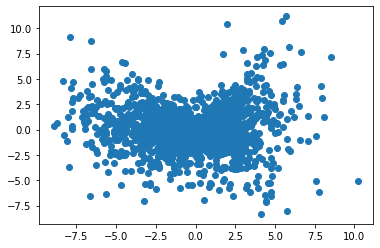

In [27]:
X = model[model.wv.vocab] # retrieving all vectors from the trained model
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])

### References: 

   - http://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/
   - https://machinelearningmastery.com/what-are-word-embeddings/
   - https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
   - https://machinelearningmastery.com/statistical-language-modeling-and-neural-language-models/
   - https://radimrehurek.com/gensim/auto_examples/index.html#documentation
   - https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
   - https://www.coursera.org/lecture/probabilistic-models-in-nlp/continuous-bag-of-words-model-hW72r
   - https://www.kaggle.com/jannesklaas/17-nlp-and-word-embeddings
   - https://www.shanelynn.ie/get-busy-with-word-embeddings-introduction/ 
   - https://www.tensorflow.org/tutorials/text/word2vec
   - http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
   - https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/ 
   - https://nlp.stanford.edu/projects/glove/ 
   - https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4 
   - Harris, Z. S. (1954). Distributional structure. Word, 10, 146–162.
   - Bengio Y., Schwenk H., Senecal JS., Morin F., Gauvain JL. (2006) Neural Probabilistic Language Models. In: Holmes D.E., Jain L.C. (eds) Innovations in Machine Learning. Studies in Fuzziness and Soft Computing, vol. 194. Springer, Berlin, Heidelberg.
   - Goldberg, Y (2017). Neural Network Methods for Natural Language Processing. Vol. 37. San Rafael, CA: Morgan & Claypool.